In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

## Посмотрим на наши данные

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.head(5)

,x,y
0,3.301849,-2.352924
1,0.579044,-3.159245
2,0.609394,-3.118413
3,2.247319,-2.737581
4,2.314998,-2.918759


In [4]:
test_data.head(5)

,x
0,0.923999
1,0.217398
2,1.122019
3,-0.141456
4,-0.402746


In [5]:
X_train = train_data['x'].values
y_train = train_data['y'].values

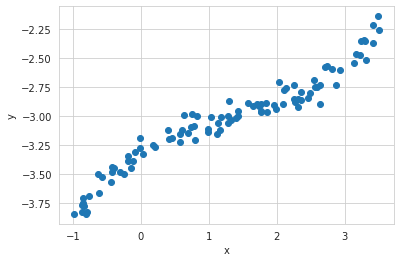

In [6]:
plt.scatter(X_train, y_train)
plt.xlabel('x');
plt.ylabel('y');

## Проверим модели, какая нам подходит лучше всего

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [α, β, ε]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 17 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-3.399,0.015,-3.426,-3.371,0.0,0.0,6074.0,7262.0,1.0
β,0.288,0.008,0.272,0.303,0.0,0.0,5840.0,6607.0,1.0
ε,0.106,0.008,0.092,0.120,0.0,0.0,9380.0,8045.0,1.0


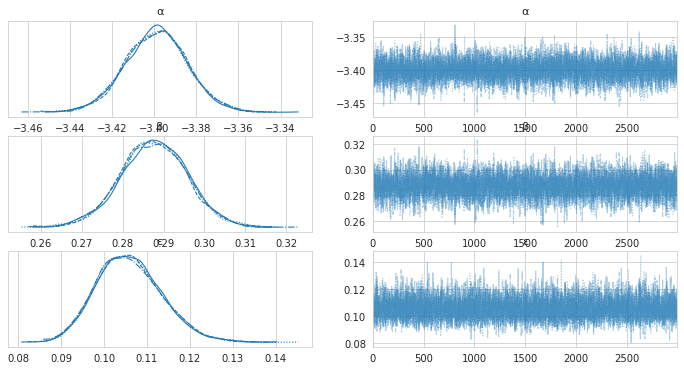

In [7]:
# Лин рег

with pm.Model() as model_1:
    α = pm.Normal('α', mu=1, sigma=10)
    β = pm.Normal('β', mu=1, sigma=1)
    ε = pm.HalfNormal('ε', 10)
    μ = pm.Deterministic('μ', α + β * X_train)
    
    y_pred_1 = pm.Normal('y_pred_1', mu=μ, sigma=ε, observed=y_train)
    trace_1 = pm.sample(3000, chains=4, cores=2, idata_kwargs={"log_likelihood": True})
    
    
az.plot_trace(trace_1, var_names=['α', 'β', 'ε']);
az.summary(trace_1).head(3)


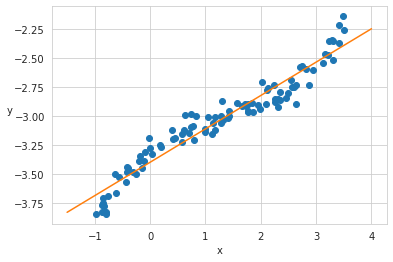

In [8]:
line_1 = trace_1.posterior.stack(samples={"chain", "draw"})

x_p = np.linspace(-1.5, 4)
y_p =   line_1['α'].mean().item() + \
        line_1['β'].mean().item() * x_p

plt.scatter(X_train,y_train)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1');

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [α, β, ε]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 19 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-3.399,0.015,-3.428,-3.373,0.0,0.0,7004.0,7796.0,1.0
β,0.288,0.008,0.272,0.303,0.0,0.0,6780.0,7458.0,1.0
ε,0.106,0.008,0.092,0.120,0.0,0.0,8496.0,8080.0,1.0


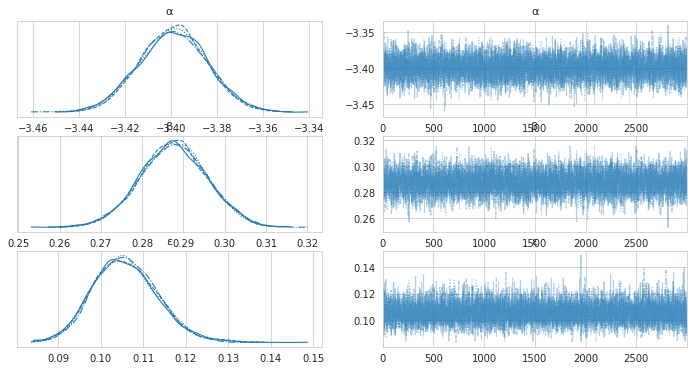

In [9]:
# Вторая 

with pm.Model() as model_2:
    α = pm.Normal('α', mu=0, sigma=10) 
    β = pm.Normal('β', mu=0, sigma=1) 
    ε = pm.HalfCauchy('ε', 10)
    
    y_pred_2 = pm.Normal('y_pred_2', mu = α + β * X_train, sigma=ε, observed=y_train)
    trace_2 = pm.sample(3000, chains=4, cores=2, idata_kwargs={"log_likelihood": True})
    
az.plot_trace(trace_2, var_names=['α', 'β', 'ε']);
az.summary(trace_2).head(3)

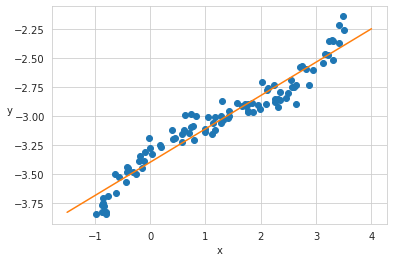

In [10]:
line_2 = trace_2.posterior.stack(samples={"chain", "draw"})

x_p = np.linspace(-1.5, 4)
y_p =   line_2['α'].mean().item() + \
        line_2['β'].mean().item() * x_p

plt.scatter(X_train,y_train)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1');

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [α_tmp, β, ε, ν_]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_tmp,-3.037,0.011,-3.057,-3.017,0.000,0.000,13518.0,7219.0,1.0
β,0.287,0.008,0.271,0.303,0.000,0.000,12012.0,6474.0,1.0
ε,0.103,0.008,0.088,0.118,0.000,0.000,10106.0,6721.0,1.0
ν_,41.270,31.458,2.741,97.955,0.317,0.242,9205.0,6213.0,1.0
ν,42.270,31.458,3.741,98.955,0.317,0.241,9205.0,6213.0,1.0
α,-3.398,0.015,-3.424,-3.369,0.000,0.000,13086.0,7415.0,1.0


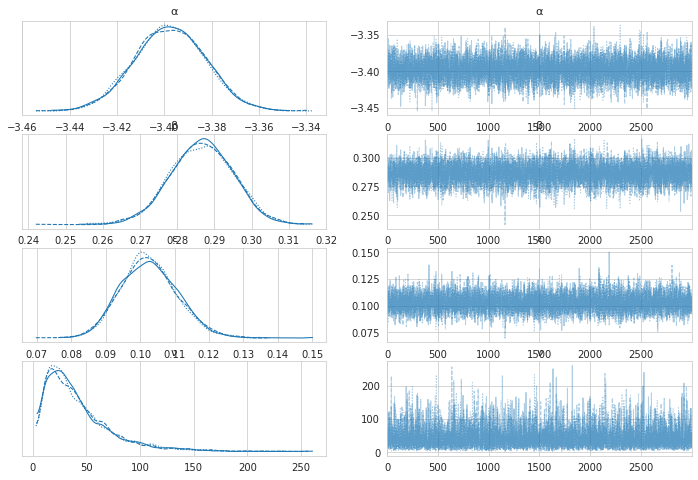

In [11]:
# Робастная модель с распределением Стьюдента, более устойчива к выбросам

x_centered = X_train - X_train.mean()

with pm.Model() as model_rob:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10) 
    β = pm.Normal('β', mu=0, sigma=10)
    ε = pm.HalfNormal('ε', 5)
    ν_ = pm.Exponential('ν_', 1/30)
    #ν_ = pm.Gamma('ν_', 2, 0.1)
    #ν_ = pm.Gamma('ν_', mu=20, sd=15)
    ν = pm.Deterministic('ν', ν_+1) # экспоненциальный сдвиг 
    
    y_pred_rob = pm.StudentT('y_pred', mu=α_tmp + β * x_centered,
                         sigma=ε, nu=ν, observed=y_train)

    α = pm.Deterministic('α', α_tmp - β * X_train.mean())
    
    trace_rob = pm.sample(3000, chains=3, idata_kwargs={"log_likelihood": True})

varnames = ['α', 'β', 'ε', 'ν']
az.plot_trace(trace_rob, var_names=varnames);
az.summary(trace_rob)

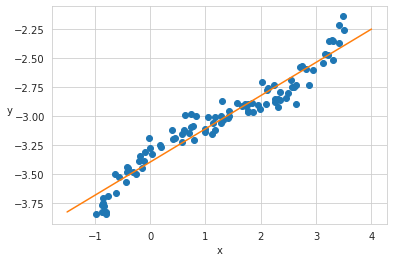

In [12]:
line_rob = trace_rob.posterior.stack(samples={"chain", "draw"})

x_p = np.linspace(-1.5, 4)
y_p =   line_rob['α'].mean().item() + \
        line_rob['β'].mean().item() * x_p

plt.scatter(X_train,y_train)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1');

In [13]:
# Полином

with pm.Model() as model_poly:
    α =  pm.Normal('α',  mu=0, sigma=10)
    β1 = pm.Normal('β1', mu=0, sigma=10)
    β2 = pm.Normal('β2', mu=0, sigma=10)
    β3 = pm.Normal('β3', mu=0, sigma=10)
    ε =  pm.Uniform('ε', lower=0, upper=10)    
    mu = α + β1 * X_train + β2 * X_train**2 + β3 * X_train**3
    
    y_pred_poly = pm.Normal('y_pred', mu=mu, sigma=ε, observed=y_train)
    trace_poly = pm.sample(3000, chains=4, cores = 4, target_accept=0.95, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, β2, β3, ε]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 89 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-3.305,0.013,-3.329,-3.282,0.0,0.0,5562.0,6678.0,1.0
β1,0.378,0.014,0.352,0.403,0.0,0.0,5087.0,5896.0,1.0
β2,-0.171,0.015,-0.200,-0.143,0.0,0.0,3950.0,4817.0,1.0
β3,0.043,0.004,0.036,0.050,0.0,0.0,4265.0,5214.0,1.0
ε,0.069,0.005,0.060,0.079,0.0,0.0,6188.0,5713.0,1.0


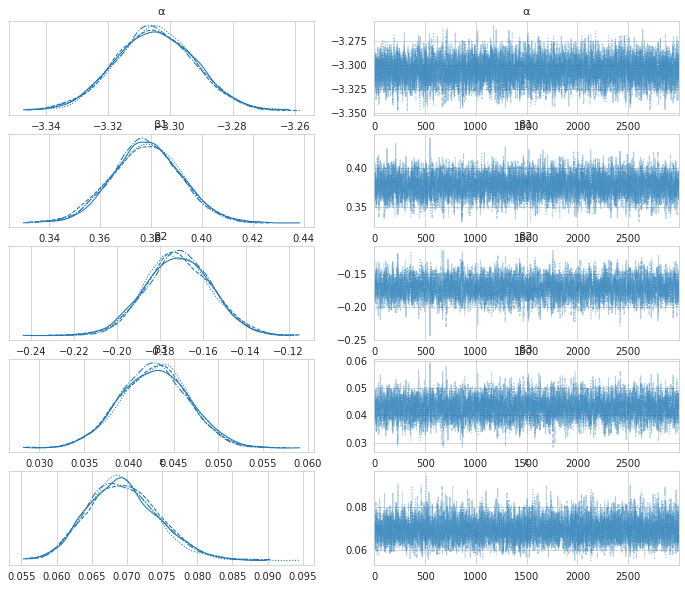

In [14]:
az.plot_trace(trace_poly);
az.summary(trace_poly)

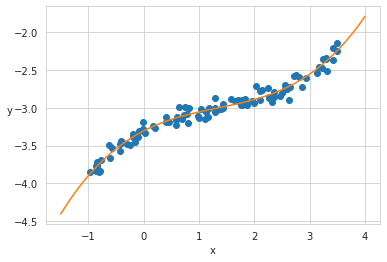

In [15]:
line_poly = trace_poly.posterior.stack(samples={"chain", "draw"})

x_p = np.linspace(-1.5, 4)
y_p =   line_poly['α'].mean().item() + \
        line_poly['β1'].mean().item() * x_p + \
        line_poly['β2'].mean().item() * x_p**2 + \
        line_poly['β3'].mean().item() * x_p**3

plt.scatter(X_train,y_train)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1');

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, β2, β3, β4, ε]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 295 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-3.311,0.015,-3.340,-3.282,0.0,0.0,4034.0,5456.0,1.0
β1,0.386,0.017,0.354,0.418,0.0,0.0,4548.0,6366.0,1.0
β2,-0.159,0.024,-0.204,-0.113,0.0,0.0,3441.0,4653.0,1.0
β3,0.031,0.018,-0.002,0.065,0.0,0.0,3052.0,4345.0,1.0
β4,0.002,0.003,-0.004,0.009,0.0,0.0,3196.0,4394.0,1.0
ε,0.070,0.005,0.060,0.079,0.0,0.0,6313.0,6598.0,1.0


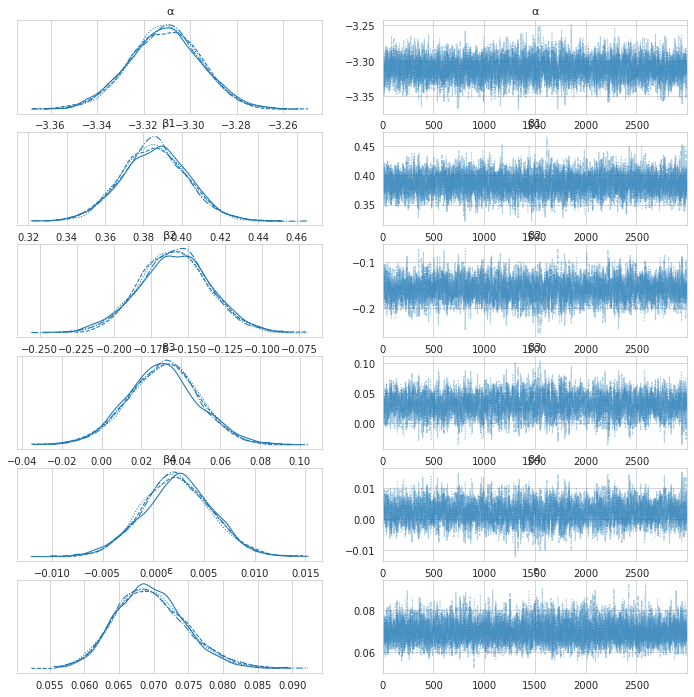

In [16]:
# Полином 4 степени

with pm.Model() as model_poly_4:
    α =  pm.Normal('α',  mu=0, sigma=10)
    β1 = pm.Normal('β1', mu=0, sigma=10)
    β2 = pm.Normal('β2', mu=0, sigma=10)
    β3 = pm.Normal('β3', mu=0, sigma=10)
    β4 = pm.Normal('β4', mu=0, sigma=10)
    ε =  pm.Uniform('ε', lower=0, upper=10)    
    mu = α + β1 * X_train + β2 * X_train**2 + β3 * X_train**3 + β4 * X_train**4
    
    y_pred_poly_4 = pm.Normal('y_pred', mu=mu, sigma=ε, observed=y_train)
    trace_poly_4 = pm.sample(3000, chains=4, cores = 4, target_accept=0.95, idata_kwargs={"log_likelihood": True})
    
az.plot_trace(trace_poly_4);
az.summary(trace_poly_4)

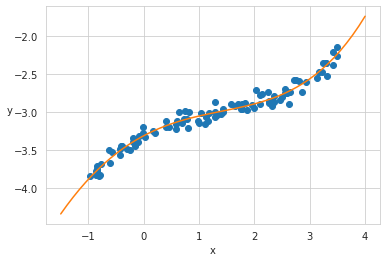

In [17]:
line_poly_4 = trace_poly_4.posterior.stack(samples={"chain", "draw"})

x_p = np.linspace(-1.5, 4)
y_p =   line_poly_4['α'].mean().item() + \
        line_poly_4['β1'].mean().item() * x_p + \
        line_poly_4['β2'].mean().item() * x_p**2 + \
        line_poly_4['β3'].mean().item() * x_p**3 + \
        line_poly_4['β4'].mean().item() * x_p**4

plt.scatter(X_train,y_train)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1');

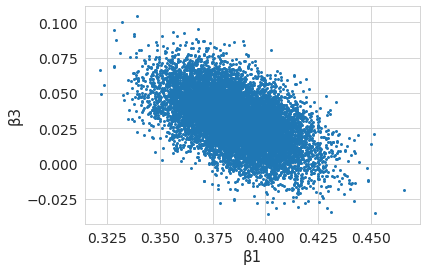

In [28]:
az.plot_pair(trace_poly_4, var_names=['β1', 'β3']);

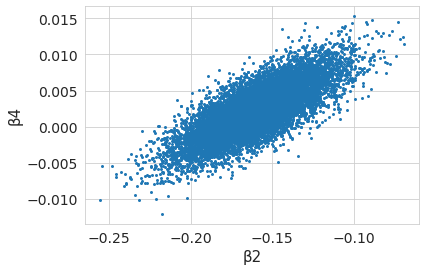

In [29]:
az.plot_pair(trace_poly_4, var_names=['β2', 'β4']);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, β2, β3, β4, β5, ε]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1232 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-3.310,0.015,-3.340,-3.283,0.000,0.0,5090.0,6021.0,1.0
β1,0.357,0.032,0.296,0.416,0.001,0.0,3646.0,4610.0,1.0
β2,-0.152,0.025,-0.199,-0.107,0.000,0.0,5278.0,6215.0,1.0
β3,0.066,0.037,-0.006,0.136,0.001,0.0,3268.0,3813.0,1.0
β4,-0.020,0.021,-0.060,0.018,0.000,0.0,3333.0,3731.0,1.0
β5,0.004,0.003,-0.003,0.009,0.000,0.0,3535.0,4518.0,1.0
ε,0.070,0.005,0.060,0.079,0.000,0.0,6137.0,6484.0,1.0


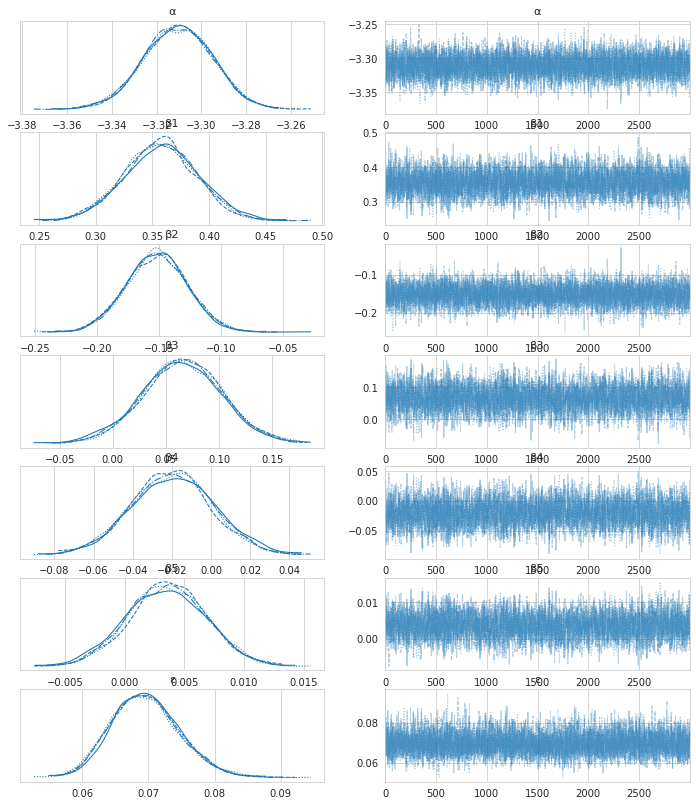

In [19]:
# Полином 5 степени

with pm.Model() as model_poly_5:
    α =  pm.Normal('α',  mu=0, sigma=10)
    β1 = pm.Normal('β1', mu=0, sigma=10)
    β2 = pm.Normal('β2', mu=0, sigma=10)
    β3 = pm.Normal('β3', mu=0, sigma=10)
    β4 = pm.Normal('β4', mu=0, sigma=10)
    β5 = pm.Normal('β5', mu=0, sigma=10)
    ε =  pm.Uniform('ε', lower=0, upper=10)    
    mu = α + β1 * X_train + β2 * X_train**2 + β3 * X_train**3 + β4 * X_train**4 + β5 * X_train**5
    
    y_pred_poly_5 = pm.Normal('y_pred', mu=mu, sigma=ε, observed=y_train)
    trace_poly_5 = pm.sample(3000, chains=4, cores = 4, target_accept=0.95, idata_kwargs={"log_likelihood": True})
    
az.plot_trace(trace_poly_5);
az.summary(trace_poly_5)

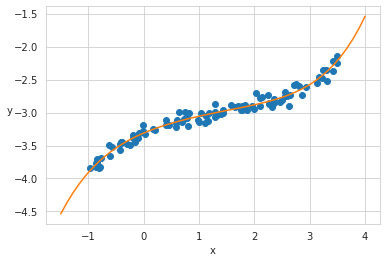

In [20]:
line_poly_5 = trace_poly_5.posterior.stack(samples={"chain", "draw"})

x_p = np.linspace(-1.5, 4)
y_p =   line_poly_5['α'].mean().item() + \
        line_poly_5['β1'].mean().item() * x_p + \
        line_poly_5['β2'].mean().item() * x_p**2 + \
        line_poly_5['β3'].mean().item() * x_p**3 + \
        line_poly_5['β4'].mean().item() * x_p**4 + \
        line_poly_5['β5'].mean().item() * x_p**5

plt.scatter(X_train,y_train)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1');

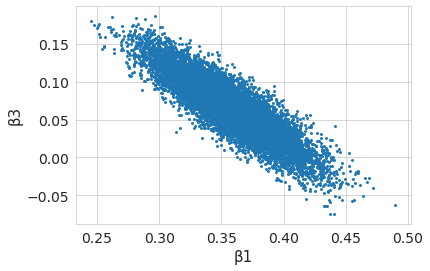

In [30]:
az.plot_pair(trace_poly_5, var_names=['β1', 'β3']);

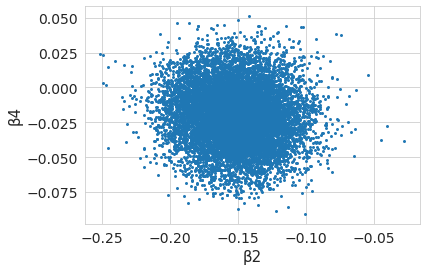

In [31]:
az.plot_pair(trace_poly_5, var_names=['β2', 'β4']);

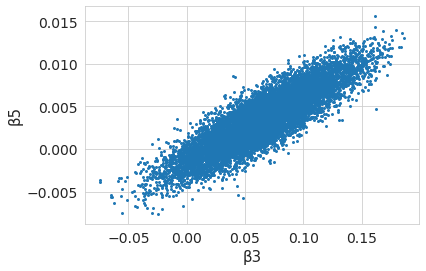

In [32]:
az.plot_pair(trace_poly_5, var_names=['β3', 'β5']);

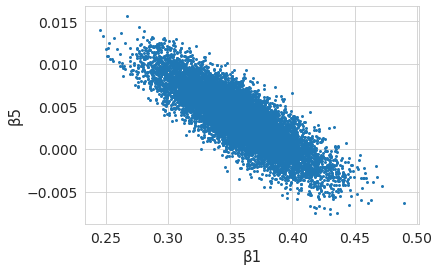

In [33]:
az.plot_pair(trace_poly_5, var_names=['β1', 'β5']);

## Сравнение моделей

In [21]:
traces = [trace_1, trace_2, trace_rob, trace_poly, trace_poly_4, trace_poly_5]

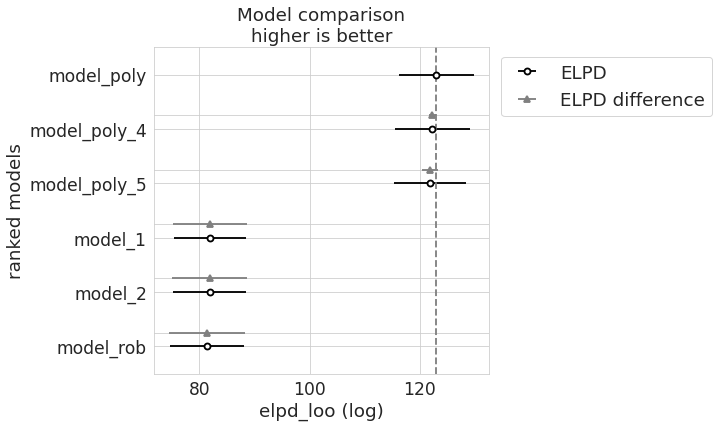

In [22]:
model_dict = dict(zip(["model_1", "model_2", "model_rob", "model_poly", "model_poly_4", "model_poly_5"], traces))
comp = az.compare(model_dict)
comp
az.plot_compare(comp);

### Как видим, полиномиальная модель степени 3 подходит нам лучше всего

In [23]:
#Информационные критерииpd.read_csv('test.csv')

loo_1 = az.loo(trace_1)
loo_2 = az.loo(trace_2)
loo_rob = az.loo(trace_rob)
loo_poly = az.loo(trace_poly)
loo_poly_4 = az.loo(trace_poly_4)
loo_poly_5 = az.loo(trace_poly_5)


waic_1 = az.waic(trace_1)
waic_2 = az.waic(trace_2)
waic_rob = az.waic(trace_rob)
waic_poly = az.waic(trace_poly)
waic_poly_4 = az.waic(trace_poly_4)
waic_poly_5 = az.waic(trace_poly_5)


/home/yashamov/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/yashamov/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [24]:
diff_loo = az.compare(model_dict)
diff_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_poly,0,122.983144,4.846479,0.000000,9.978377e-01,6.806834,0.000000,False,log
model_poly_4,1,122.335325,5.621750,0.647820,2.622212e-14,6.755897,0.665112,False,log
model_poly_5,2,121.944795,6.535860,1.038350,2.162255e-03,6.528793,1.431609,False,log
model_1,3,81.885148,3.087861,41.097996,0.000000e+00,6.559710,6.740768,False,log
model_2,4,81.831560,3.150183,41.151584,0.000000e+00,6.574695,6.747816,False,log
model_rob,5,81.370980,3.266325,41.612164,2.220446e-16,6.656694,6.870131,False,log


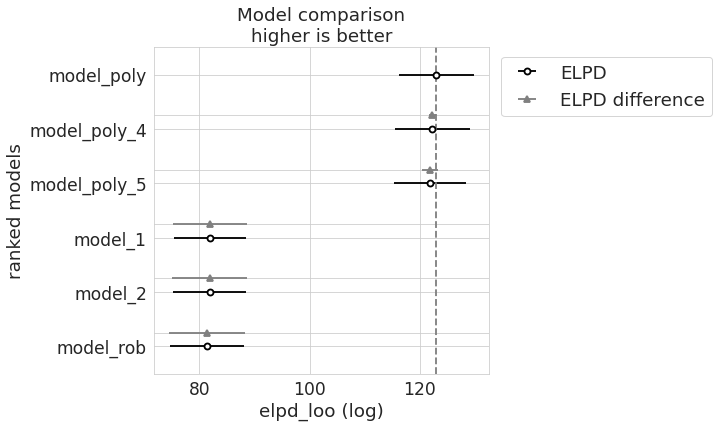

In [25]:
az.plot_compare(diff_loo);

In [26]:
diff_waic = az.compare(model_dict, ic = 'waic')
diff_waic

/home/yashamov/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/yashamov/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
model_poly,0,123.012282,4.817342,0.000000,9.756696e-01,6.802686,0.000000,False,log
model_poly_4,1,122.376642,5.580434,0.635640,0.000000e+00,6.749645,0.664551,True,log
model_poly_5,2,122.020865,6.459789,0.991416,2.433044e-02,6.521099,1.432587,True,log
model_1,3,81.893649,3.079360,41.118633,5.820375e-16,6.557836,6.741207,False,log
model_2,4,81.842559,3.139184,41.169722,3.951069e-15,6.571956,6.748044,False,log
model_rob,5,81.380527,3.256778,41.631755,0.000000e+00,6.654721,6.870283,False,log


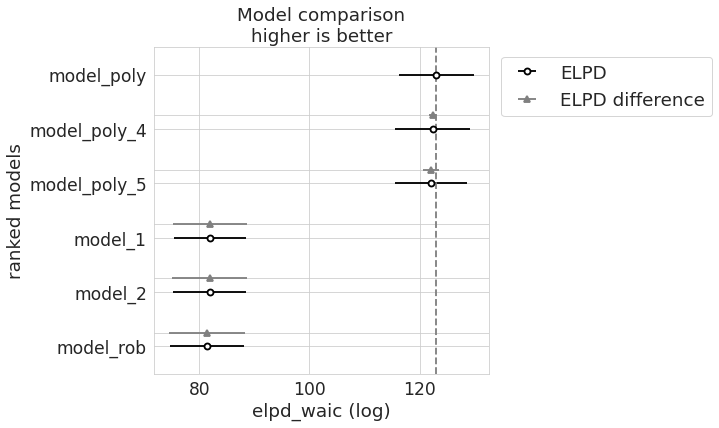

In [27]:
az.plot_compare(diff_waic);

### Как видим, полиномиальная модель степени 3 подходит нам лучше всего

## Предсказание на тестовых данных

In [34]:
# Используем нашу полиномиальную модель

with pm.Model() as model_poly:
    α =  pm.Normal('α',  mu=0, sigma=10)
    β1 = pm.Normal('β1', mu=0, sigma=10)
    β2 = pm.Normal('β2', mu=0, sigma=10)
    β3 = pm.Normal('β3', mu=0, sigma=10)
    ε =  pm.Uniform('ε', lower=0, upper=10)    
    mu = α + β1 * X_train + β2 * X_train**2 + β3 * X_train**3
    
    y_pred_poly = pm.Normal('y_pred', mu=mu, sigma=ε, observed=y_train)
    trace_poly = pm.sample(3000, chains=4, cores = 4, target_accept=0.95, idata_kwargs={"log_likelihood": True})
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, β2, β3, ε]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 86 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-3.305,0.013,-3.329,-3.281,0.0,0.0,4493.0,5540.0,1.0
β1,0.378,0.014,0.353,0.404,0.0,0.0,5199.0,6009.0,1.0
β2,-0.172,0.015,-0.200,-0.143,0.0,0.0,3502.0,4450.0,1.0
β3,0.043,0.004,0.036,0.050,0.0,0.0,3730.0,4824.0,1.0
ε,0.069,0.005,0.060,0.079,0.0,0.0,6021.0,6261.0,1.0


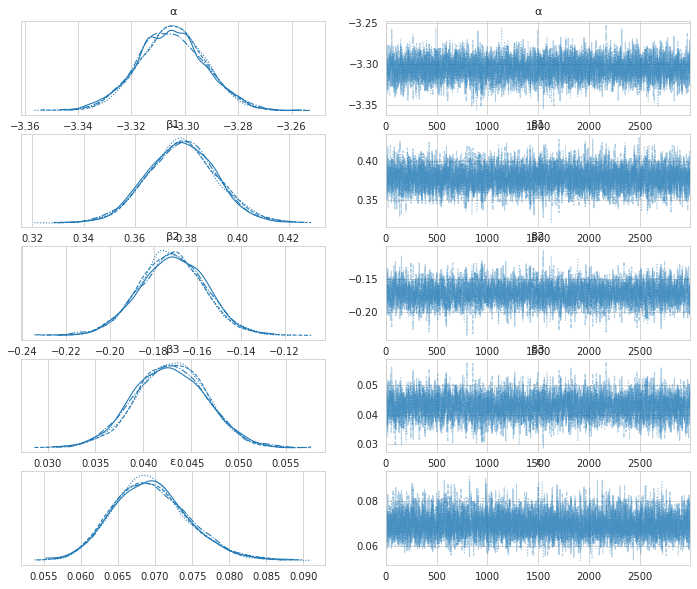

In [35]:
az.plot_trace(trace_poly);
az.summary(trace_poly)

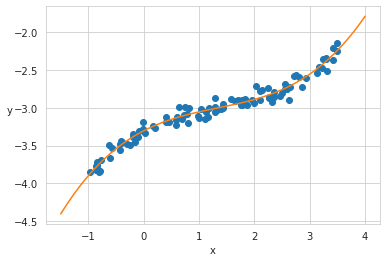

In [36]:
line_poly = trace_poly.posterior.stack(samples={"chain", "draw"})

x_p = np.linspace(-1.5, 4)
y_p =   line_poly['α'].mean().item() + \
        line_poly['β1'].mean().item() * x_p + \
        line_poly['β2'].mean().item() * x_p**2 + \
        line_poly['β3'].mean().item() * x_p**3

plt.scatter(X_train,y_train)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1');

In [37]:
test_data = pd.read_csv('test.csv')
X_test = test_data['x'].values

# Вот наш предикт
y_pred_test = line_poly['α'].mean().item() + \
        line_poly['β1'].mean().item() * X_test + \
        line_poly['β2'].mean().item() * X_test**2 + \
        line_poly['β3'].mean().item() * X_test**3

Text(0, 0.5, 'y')

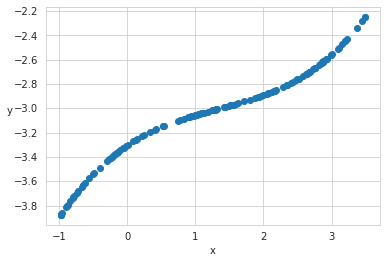

In [38]:
plt.scatter(X_test,y_pred_test)
plt.xlabel('x')
plt.ylabel('y', rotation=0)

In [39]:
from sklearn.metrics import mean_squared_error

In [40]:

# y_true = pd.read_csv('test_Y_true_reg.csv')
# mean_squared_error(y_true, y_pred_test)

In [41]:
submission = pd.DataFrame()

submission = pd.read_csv('test.csv')
submission['y'] = y_pred_test
submission.to_csv('final_submission.csv',index=False)

In [42]:
submission

,x,y
0,0.923999,-3.067994
1,0.217398,-3.230340
2,1.122019,-3.035848
3,-0.141456,-3.362005
4,-0.402746,-3.487952
...,...,...
137,2.866762,-2.620057
138,1.033005,-3.049915
139,0.413333,-3.174824
140,-0.833086,-3.764046


In [43]:
#plt.scatter(submission['x'].values,submission['y'].values)